### Desafío - Naive Bayes

- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    -El desafío se debe desarrollar de manera Individual.
    -Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío
    - Naive Bayes.
### Descripción
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump dentro del proyecto.

- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.

- En base a esta información, se les pide un modelo generativo que pueda predecir el género de una canción a partir de la letra de una canción.

- Existen 4 géneros que se registran en la base de datos, por lo que para esta actividad trabajaremos con un Multinomial Naive Bayes.

### Ejercicio 1: Preparar el ambiente de trabajo
- Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump.
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente generé un objeto pd.DataFrame que contenga todos los csv.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.


In [1]:
# Triada calsica.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Graficos seaborn, warnings y datos perdidos.
import seaborn as sns
import warnings
import missingno as msngo

# Importaciones especificas de este desafio.
import glob, os

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Otras librerias, configuraciones e instancias.
labelencoder = LabelEncoder()
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('seaborn-darkgrid')


In [2]:
csv_list = glob.glob('dump/*.csv')
name_csv = []

In [3]:
for i in csv_list:
    name_csv.append(pd.read_csv(i, index_col=None, header=0).drop(columns='Unnamed: 0'))
    
df_letras = pd.concat(name_csv)
df_letras.columns = ['Artista', 'Genero', 'Cancion', 'Letra'] # ['Artist', 'Genre', 'Song', 'Lyrics']

In [4]:
csv_list[:10]

['dump\\anthrax_scrape.csv',
 'dump\\a_tribe_called_quest_scrape.csv',
 'dump\\black_star_scrape.csv',
 'dump\\bob_dylan_scrape.csv',
 'dump\\britney_spears_scrape.csv',
 'dump\\bruce_springsteen_scrape.csv',
 'dump\\cannibal_corpse_scrape.csv',
 'dump\\carly_rae_jepsen_scrape.csv',
 'dump\\deicide_scrape.csv',
 'dump\\de_la_soul_scrape.csv']

In [5]:
name_csv[0]

,0,1,2,3
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...
...,...,...,...,...
165,Anthrax,metal,She,"(Written by Gene Simmons and Steve Coronel), \..."
166,Anthrax,metal,Destroyer,(Snider) \n Twisted Forever (Twisted Sister tr...
167,Anthrax,metal,It's Late,You say you love me and I hardly know your nam...
168,Anthrax,metal,Burnin' Up,"You stitch me up good, and you cut me down \n ..."


In [6]:
df_letras.head()

,Artista,Genero,Cancion,Letra
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


### Ejercicio 2: Descripción de los datos
- Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman la siguiente información:
    - La cantidad de canciones registradas por cada artista, ordenados de mayor a menor.
    - La cantidad de canciones registradas en cada género, ordenados de mayor a menor.
    
- Comente sobre las principales tendencias.


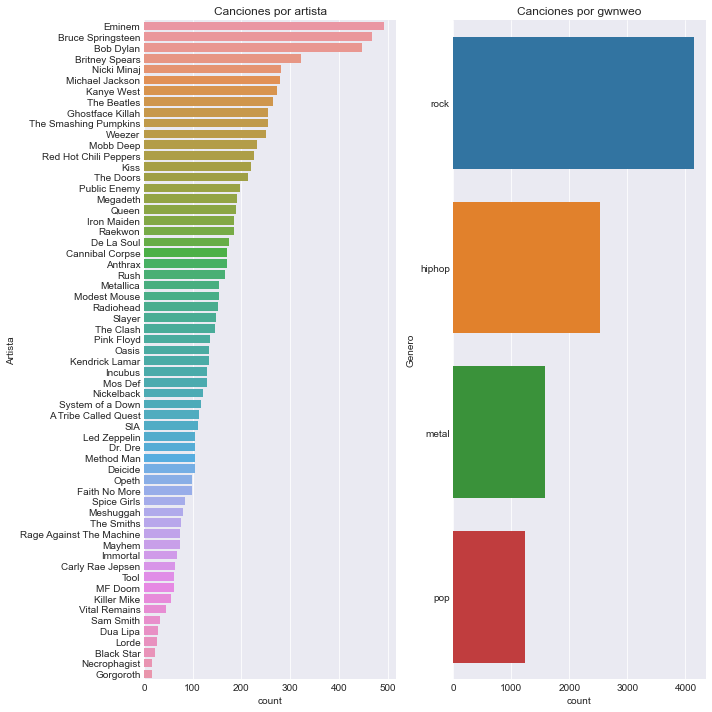

In [7]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
sns.countplot(y=df_letras['Artista'], order = df_letras['Artista'].value_counts().index)
plt.title('Canciones por artista')
plt.tight_layout()

plt.subplot(1, 2,2)
sns.countplot(y=df_letras['Genero'], order = df_letras['Genero'].value_counts().index)
plt.title('Canciones por genero')
plt.tight_layout()

### Ejercicio 3: Matriz de ocurrencias
#### Digresión: Tokenización de Textos
Para poder trabajar con textos, debemos pasarlos a una matriz dispersa, donde cada fila
representará una entrada (en este caso, una canción), y cada columna representará una
palabra (token). Este es el proceso de tokenización: Identificar la ocurrencia de una palabra
específica dentro de un conjunto de textos (corpus).

El tokenizador más simple sklearn.feature_extraction.text.CountVectorizer genera
una colección de textos a una matriz que representa la frecuencia dentro del texto de una
palabra específica.
vectorizer=CountVectorizer(stop_words='english')
El tokenizador funciona de la siguiente manera:


In [11]:
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english')

In [12]:
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(df_letras.Letra)

In [13]:
# Extraemos tokens (palabras)
words  = count_vectorizer.get_feature_names()

In [14]:
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

In [15]:
# creamos un nuevo dataframe
words_freq_df = pd.DataFrame([list(words), list(words_freq)]).T

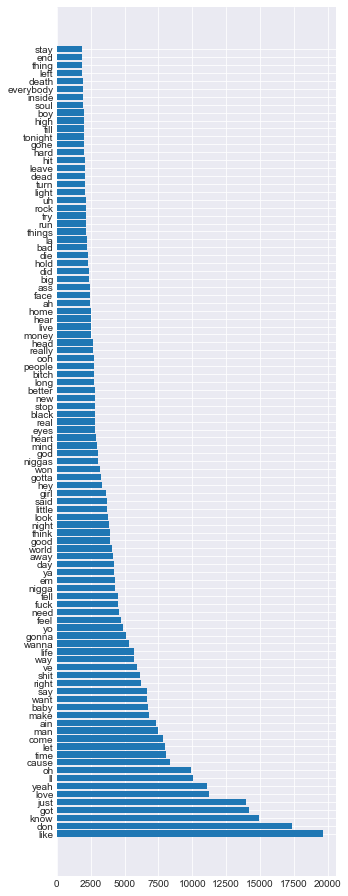

In [16]:
# visualizacion de tokens
words_freq_df.columns= ['words', 'freq']
words_freq_df = words_freq_df.sort_values(by='freq', ascending=False).iloc[0:100, :]

plt.figure(figsize=(5, 16))
plt.barh(words_freq_df['words'], words_freq_df['freq']);

In [17]:
def word_count_genero(vectorizer=CountVectorizer(stop_words = 'english', ngram_range=(1, 2)), df = df_letras, target = 'Letra', genre = 'hiphop', sort_n = 100):
    tmp_vect = vectorizer
    tmp_fit_transform = tmp_vect.fit_transform(df[df['Genero'] == genre][target])
    tmp_words = tmp_vect.get_feature_names()
    tmp_frequencies = tmp_fit_transform.toarray().sum(axis = 0)
    tmp_df = pd.DataFrame([ list(tmp_words), list(tmp_frequencies) ]).T
    tmp_df.columns = ['words', 'freq']
    tmp_df = tmp_df.sort_values(by = 'freq', ascending = False).iloc[0:sort_n, :]
    plt.barh(tmp_df['words'],tmp_df['freq'])

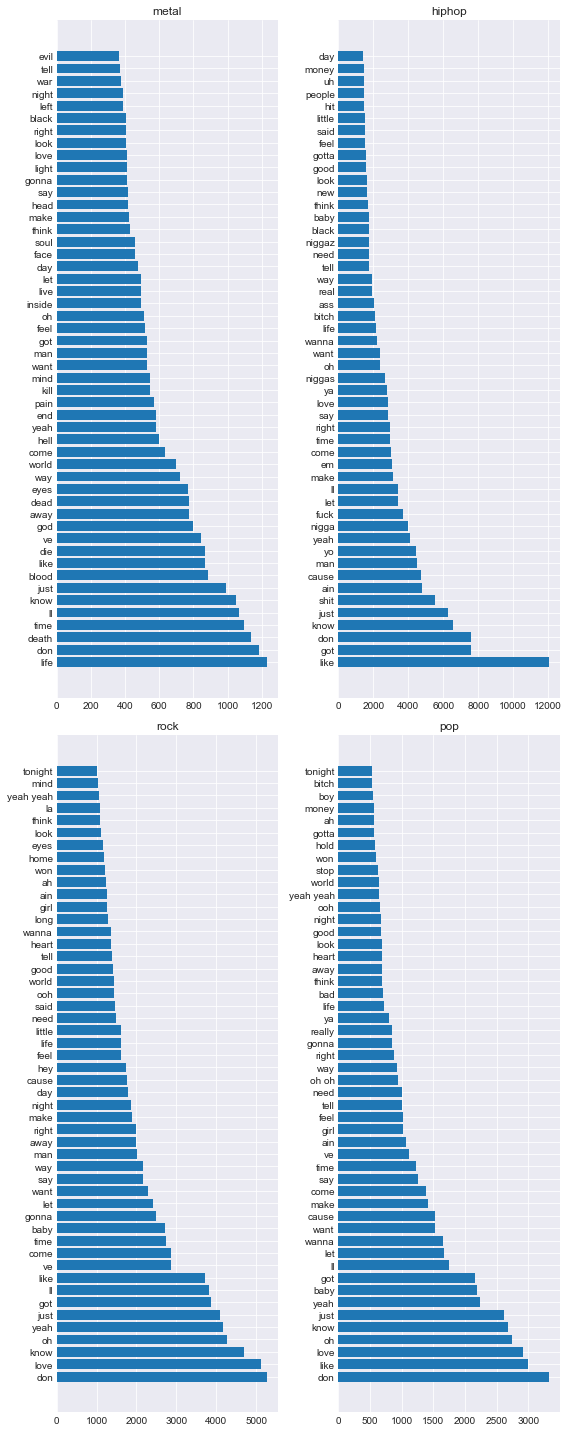

In [18]:
# Tokens en categoria Genero
plt.figure(figsize=(8, 20))
for index, gen in enumerate(df_letras['Genero'].unique()):
    plt.subplot(2, 2, index + 1)
    word_count_genero(genre=gen, sort_n=50)
    plt.title(gen)
    plt.tight_layout()

### Ejercicio 4: Entrenamiento del Modelo

#### Digresión: sklearn Pipelines
La clase Pipeline del módulo sklearn.pipeline permite concatenar múltiples pasos de
procesamiento y preprocesamiento en un estimador generado por algún método de
scikit-learn. En sí, la clase cuenta con los métodos clásicos fit, predict y score y
presenta un comportamiento idéntico a los demás objetos de scikit-learn. Uno de los
usos más comunes es para concatenar pasos de preprocesamiento con un modelo.

#### Componentes de un Pipeline
Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de
datos, deseo Estandarizar, posteriormente extraer sus principales componentes y
finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:

pipeline_model = Pipeline([('scale', StandardScaler()),
('pca', RandomizedPCA(n_components=3)),
('model', LinearRegression())])

Algunos de los elementos a considerar:
1. Cada paso se considera como una tupla, donde se declara el nombre del paso y la
función a implementar. En este caso, nuestro primer paso es estandarizar la matriz,
por lo que asociamos el método StandardScaler con el string scale.
2. Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso
representa el orden de ejecución.

Posteriormente el objeto creado puede utilizarse con los siguientes métodos

pipeline_model.fit(X_train, y_train)
y_hat = pipeline_model.predict(y_test)

- Importe MultinomialNB, train_test_split, Pipeline, confusion_matrix y classification_report.
- Genere las muestras de entrenamiento y validación reservando un 40% para validación y declarando una semilla pseudoaleatoria.
- Monte el modelo dentro de un Pipeline, donde el primer paso es implementar CountVectorizer y el segundo es ejecutar el clasificador MultinomialNB.
- A continuación se les presenta una lista de letras, ¿cuáles serían las predicciones correspondientes?

In [19]:
'''['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma
Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your
game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye
Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move
bitch, get out the way Get out the way bitch, get out the way', #
Ludacris - Move B*tch
'Sexual violence doesn't start and end with rape It starts in our books
and behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma
I'm the one who had to learn to \
build a heart made of armor From the girl who made you soup and tied
your shoes when you were hurting\
You are not deserving, you are not deserving" #Banks - Drowning]'''

'[\'I got a place in the underworld\', # Brody Dalle - Underworld\n\'As veils of ignorance, hatred retains Storm of arrows through karma\nSeeking light through samsara\', # Gorguts - Forgotten Arrows\n"Bye bye Don\'t want to be a fool for you Just another player in your\ngame for two You may hate me but it ain\'t no lie", # N\'SYNC - Bye Bye\nBye\n\'Move bitch, get out the way Get out the way bitch, get out the way Move\nbitch, get out the way Get out the way bitch, get out the way\', #\nLudacris - Move B*tch\n\'Sexual violence doesn\'t start and end with rape It starts in our books\nand behind our school gates\' # IDLES - Mother,\n"Take it from the girl you claimed to love You gonna get some bad karma\nI\'m the one who had to learn to build a heart made of armor From the girl who made you soup and tied\nyour shoes when you were hurtingYou are not deserving, you are not deserving" #Banks - Drowning]'

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_letras['Letra'], df_letras['Genero'], test_size = .33, random_state = 15820)

In [21]:
texto_clasifier = Pipeline( [('vect', CountVectorizer(stop_words='english')), ('clf', MultinomialNB(alpha=0.1))])

In [22]:
texto_clasifier.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('clf', MultinomialNB(alpha=0.1))])

In [23]:
predic = texto_clasifier.predict(X_test)
predic[:10]

array(['hiphop', 'hiphop', 'hiphop', 'rock', 'pop', 'hiphop', 'metal',
       'hiphop', 'rock', 'rock'], dtype='<U6')

In [24]:
confusion_matrix(y_test,predic)

array([[ 757,    3,   20,   28],
       [  18,  409,    4,   86],
       [  42,   12,  209,  158],
       [  69,   95,   85, 1137]], dtype=int64)

In [25]:
(pd.crosstab(y_test,predic, normalize=True)*100).round(1)

col_0,hiphop,metal,pop,rock
Genero,,,,
hiphop,24.2,0.1,0.6,0.9
metal,0.6,13.1,0.1,2.7
pop,1.3,0.4,6.7,5.0
rock,2.2,3.0,2.7,36.3


In [26]:
texto_clasifier.predict(['I got a place in the underworld', # Brody Dalle - Underworld 
                  'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
                  "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
                  'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris - Move B*tch 
                  "Sexual violence doesn't start and end with rape It starts in our books and behind our school gates", # IDLES - Mother,
                  "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning 
                 ])

array(['metal', 'metal', 'rock', 'pop', 'metal', 'rock'], dtype='<U6')

In [27]:
predic_clasifier = texto_clasifier.predict(X_test)
predic_clasifier[:10]

array(['hiphop', 'hiphop', 'hiphop', 'rock', 'pop', 'hiphop', 'metal',
       'hiphop', 'rock', 'rock'], dtype='<U6')

In [28]:
confusion_matrix(y_test, predic_clasifier)

array([[ 757,    3,   20,   28],
       [  18,  409,    4,   86],
       [  42,   12,  209,  158],
       [  69,   95,   85, 1137]], dtype=int64)

In [29]:
print(classification_report(y_test, predic_clasifier))

              precision    recall  f1-score   support

      hiphop       0.85      0.94      0.89       808
       metal       0.79      0.79      0.79       517
         pop       0.66      0.50      0.57       421
        rock       0.81      0.82      0.81      1386

    accuracy                           0.80      3132
   macro avg       0.78      0.76      0.77      3132
weighted avg       0.80      0.80      0.80      3132



### Ejercicio 5: Mejora del Modelo
- Proponga una estrategia para mejorar el desempeño del modelo en la categoría con peores métricas.
- Repita los pasos de entrenamiento y reporte de métricas, esta vez incluyendo los nuevos datos suministrados.
- Comente sobre el desempeño general de este.


In [30]:
append_file = []
# pasamos nuevo set de datos
file = glob.glob('dump_plus_pop/*.csv')
for i in file:
    append_file.append(pd.read_csv(i, index_col=None, header=0).drop(columns='Unnamed: 0'))

In [31]:
lyrics = pd.concat(append_file)
lyrics.columns = ['Artista', 'Genero', 'Cancion', 'Letra']
lyrics.index = pd.RangeIndex(len(lyrics.index))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(lyrics['Letra'], lyrics['Genero'], test_size = .33, random_state = 15820)

In [33]:
text = Pipeline(
    [('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [34]:
text.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [35]:
predic_y = text.predict(X_test)
predic_y[:10]

array(['hiphop', 'hiphop', 'pop', 'pop', 'pop', 'rock', 'pop', 'pop',
       'pop', 'hiphop'], dtype='<U6')

In [36]:
confusion_matrix(y_test,predic_y)

array([[ 761,    2,   54,   38],
       [  16,  349,   37,  119],
       [  76,    5,  577,  150],
       [  59,   50,  265, 1008]], dtype=int64)

In [37]:
print(classification_report(y_test, predic_y))

              precision    recall  f1-score   support

      hiphop       0.83      0.89      0.86       855
       metal       0.86      0.67      0.75       521
         pop       0.62      0.71      0.66       808
        rock       0.77      0.73      0.75      1382

    accuracy                           0.76      3566
   macro avg       0.77      0.75      0.76      3566
weighted avg       0.76      0.76      0.76      3566

